In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


In [2]:
# mmint
data_path = '/home/mmint/Desktop/drawing_evaluation'
datalegend_path =  os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')
# mik:
# data_path = '/Users/mik/Desktop/bubble_files/drawing_evaluation'
# datalegend_path = os.path.join(data_path, 'drawing_evaluation_DataLegend.csv')

loaded_df = pd.read_csv(datalegend_path)

loaded_df

,EvaluationFileCode,ReferenceFileCode,ActionsFileCode,ObjectName,SceneName,ControllerMethod,ObjectPoseEstimator,Score,NumSteps,NumStepsExpected,ObservationFileCodes
0,32,1,32,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,33.246501,29,40,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,66,33,66,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,21.471634,31,40,"[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4..."
2,100,67,100,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,29.595433,31,40,"[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 7..."
3,138,101,138,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,25.907281,35,40,"[102, 103, 104, 105, 106, 107, 108, 109, 110, ..."
4,175,139,175,amazon,line_drawing,bubble_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,29.912956,34,40,"[140, 141, 142, 143, 144, 145, 146, 147, 148, ..."
...,...,...,...,...,...,...,...,...,...,...,...
605,14213,14180,14213,amazon,veesa_as_amazon,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,12.952189,31,40,"[14181, 14182, 14183, 14184, 14185, 14186, 141..."
606,14245,14214,14245,crayola,loddie_as_crayola,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,14.473569,29,40,"[14215, 14216, 14217, 14218, 14219, 14220, 142..."
607,14265,14246,14265,crayola,loddie_as_crayola,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,54.610371,17,40,"[14247, 14248, 14249, 14250, 14251, 14252, 142..."
608,14283,14266,14283,crayola,loddie_as_crayola,object_pose_dynamics_model_mppi,ICPApproximationModelOutputObjectPoseEstimation,149.501715,15,40,"[14267, 14268, 14269, 14270, 14271, 14272, 142..."


In [3]:
# USEFUL FUNCTIONS:
def load_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'measured_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def load_desired_drawing(fc, scene_name):
    file_path = os.path.join(data_path, scene_name, 'expected_drawing', 'color_data', '{}_color_{:06d}.npy'.format(scene_name, fc))
    with open(file_path, 'rb') as f:
        drawing = np.load(f)
    return drawing
    
def filter_img(img):
    tag_size = 150
    filtered_value = 0
    filtered_img = img.copy()
    filtered_img[:tag_size, :tag_size] = filtered_value
    filtered_img[:tag_size, -tag_size:] = filtered_value
    filtered_img[-tag_size:, :tag_size] = filtered_value
    filtered_img[-tag_size:, -tag_size:] = filtered_value
    return filtered_img

def add_new_cost_function(df, cost_function, name):
    new_scores = []
    for i, row_i in df.iterrows():
        fc = row_i['EvaluationFileCode']
        scene_name = row_i['SceneName']
        drawn_img_i = load_drawing(fc, scene_name)
        desired_img_i = load_desired_drawing(fc, scene_name)
        filtered_img_i = filter_img(drawn_img_i)
        score_i = cost_function(filtered_img_i, desired_img_i)
        new_scores.append(score_i)
    df['{}_scores'.format(name)] = new_scores
    return df

In [4]:
# SCORE FUNCTIONS:
def compute_line_mask_score(actual_drawing, desired_drawing):
    actual_drawing_filtered = actual_drawing[30:-30, 100:-80] # remove borders for possible reflections or tags.
    desired_drawing_filtered = desired_drawing[30:-30, 100:-80] # remove borders for possible reflections or tags.
    actual_drawing_line = np.sum(actual_drawing_filtered, axis=1)
    desired_drawing_line = np.sum(desired_drawing_filtered, axis=1)
    actual_drawing_norm = np.divide(actual_drawing_line.astype(np.float32), actual_drawing_line.astype(np.float32), out=np.zeros_like(actual_drawing_line, dtype=np.float32), where=actual_drawing_line!=0)
    desired_drawing_norm = np.divide(desired_drawing_line.astype(np.float32), desired_drawing_line.astype(np.float32), out=np.zeros_like(desired_drawing_line, dtype=np.float32), where=desired_drawing_line!=0)
    score = np.sum(desired_drawing_norm * actual_drawing_norm)/np.sum(desired_drawing_norm)
    return score


In [5]:
# COMPUTE SCORE STATISTICS
def compute_score_statistics(df, score_name):
    model_names = np.unique(df.ControllerMethod)
    results = []
    for model_name in model_names:
        model = df[df.ControllerMethod == model_name]
        scores = model[score_name].values
    #     scores = scores[np.where(scores<150)] # Consider filtering scores
        mu = np.mean(scores)
        std = np.std(scores)
        max_score = np.max(scores)
        min_score = np.min(scores)
        results.append([model_name, mu, std, max_score, min_score])
    new_results_df = pd.DataFrame(results, columns=['ModelName', 'mu', 'std', 'max_score', 'min_score'])
    return new_results_df

In [6]:
loaded_df = add_new_cost_function(loaded_df, compute_line_mask_score, 'line_masked')
nan_indxs = loaded_df.index[loaded_df['line_masked_scores'].isnull()].tolist()
loaded_df = loaded_df.drop(nan_indxs)

/tmp/ipykernel_1460052/3375632441.py:9: RuntimeWarning: invalid value encountered in float_scalars
  score = np.sum(desired_drawing_norm * actual_drawing_norm)/np.sum(desired_drawing_norm)


In [7]:
compute_score_statistics(loaded_df, 'line_masked_scores')

,ModelName,mu,std,max_score,min_score
0,bubble_dynamics_fixed_model_mppi,0.376012,0.219670,0.884752,0.0
1,bubble_dynamics_model_mppi,0.594463,0.278502,0.962766,0.0
2,bubble_linear_dynamics_model_mppi,0.549173,0.304102,0.950442,0.0
3,object_pose_dynamics_model_mppi,0.358364,0.240604,0.921986,0.0
4,random_action,0.083640,0.090308,0.445826,0.0


In [8]:
# rename markers for scene name '<marker_name_1>_as_<marker_name_2>'
default_scene_name = 'line_drawing_updated_icp_approx'
all_scene_names = np.unique(loaded_df.SceneName)
scenes_names_cheat_marker = [sn for sn in all_scene_names if '_as_' in sn]
scenes_names_cheat_marker
# replace them for the marker name 
for sn_i in scenes_names_cheat_marker:
    loaded_df.loc[loaded_df.SceneName == sn_i, 'ObjectName'] = sn_i
    loaded_df.loc[loaded_df.SceneName == sn_i, 'SceneName'] = default_scene_name

In [9]:
df_previous_icp = loaded_df[loaded_df.SceneName == 'line_drawing']
df_updated_icp = loaded_df[loaded_df.SceneName == 'line_drawing_updated_icp_approx']
random_df = loaded_df[loaded_df.ControllerMethod == 'random_action']

# Update the filtered df with the random control results
df_updated_icp_object = np.unique(df_updated_icp.ObjectName)
random_only_selected_objects = random_df[random_df.ObjectName.isin(df_updated_icp_object)]
df_updated_icp = pd.concat([df_updated_icp, random_only_selected_objects])

array(['amazon', 'crayola', 'expo_chisel', 'expo_ultra_fine',
       'expo_ultra_fine_as_amazon', 'expo_ultra_fine_as_magnetic',
       'keebor', 'loddie', 'loddie_as_crayola', 'magnetic', 'veesa',
       'veesa_as_amazon', 'volcanics', 'volcanics_as_amazon',
       'volcanics_as_keebor'], dtype=object)

In [11]:
control_name_mapping = None
control_name_mapping_base = {
    'bubble_dynamics_model_mppi':'Bubble Dynamics',
    'bubble_linear_dynamics_model_mppi': 'Bubble Linear Dynamics',
    'object_pose_dynamics_model_mppi': 'Object Pose Dynamics',
    'bubble_dynamics_fixed_model_mppi': 'Fixed Model',
    'random_action': 'Random',
    
}
control_name_mapping_cheat = {
    'bubble_dynamics_model_mppi_cheat':'Bubble Dynamics Cheat',
    'bubble_linear_dynamics_model_mppi_cheat': 'Bubble Linear Dynamics Cheat',
    'object_pose_dynamics_model_mppi_cheat': 'Object Pose Dynamics Cheat',
    'bubble_dynamics_fixed_model_mppi_test': 'Fixed Model Test',
    'random_action_test': 'Random Test',
}
control_name_mapping = control_name_mapping_base.copy()
control_name_mapping.update(control_name_mapping_cheat)



model_order = None

def intercalar_dicts_keys(dict_list):
    out = []
    lens = [len(d_i) for d_i in dict_list]
    for i in range(np.max(lens)):
        for d_i in dict_list:
            if i < len(d_i):
                out.append(list(d_i.keys())[i])
    return out
model_order = intercalar_dicts_keys([control_name_mapping_base, control_name_mapping_cheat])

train_objects = ['amazon', 'keebor', 'crayola', 'expo_chisel', 'magnetic']
test_objects_reduced = ['veesa', 'volcanics', 'loddie']
test_objects = test_objects_reduced + ['expo_ultra_fine']
test_objects_extended = test_objects +['expo_ultra_fine_as_amazon', 'expo_ultra_fine_as_magnetic', 'volcanics_as_amazon', 'volcanics_as_keebor', 'veesa_as_amazon', 'loddie_as_crayola']
all_objects = train_objects + test_objects

palette = None
base_palette = sns.color_palette("tab10")
palette = dict(zip(all_objects,[base_palette[o_i] for o_i, obj_i in enumerate(all_objects)]))
# add model names to it:
base_palette_models = [c_i for c_i in sns.color_palette('Set2')] + [c_i for c_i in sns.color_palette("husl", 8)]

for i, control_name_i in enumerate(control_name_mapping.keys()):
    palette[control_name_i] = base_palette_models[i]
    
# other object_names
extra_palette = sns.color_palette("pastel")
obj_counter = 0
for i, obj_name_i in enumerate(all_object_names):
    if obj_name_i not in palette:
        palette[obj_name_i] = extra_palette[obj_counter]
        obj_counter += 1

In [12]:
palette.keys()

dict_keys(['amazon', 'keebor', 'crayola', 'expo_chisel', 'magnetic', 'veesa', 'volcanics', 'loddie', 'expo_ultra_fine', 'bubble_dynamics_model_mppi', 'bubble_linear_dynamics_model_mppi', 'object_pose_dynamics_model_mppi', 'bubble_dynamics_fixed_model_mppi', 'random_action', 'bubble_dynamics_model_mppi_cheat', 'bubble_linear_dynamics_model_mppi_cheat', 'object_pose_dynamics_model_mppi_cheat', 'bubble_dynamics_fixed_model_mppi_test', 'random_action_test', 'expo_ultra_fine_as_amazon', 'expo_ultra_fine_as_magnetic', 'loddie_as_crayola', 'veesa_as_amazon', 'volcanics_as_amazon', 'volcanics_as_keebor'])

In [13]:
import abc
from matplotlib.patches import PathPatch


sns.set(rc = {'figure.figsize':(30,8)}, font_scale=2)


class ScorePlotBase(object):
    def __init__(self, palette=None):
        self.palette = palette
    
    def _filter_df(self, df, add_args):
        return df
    
    @abc.abstractmethod
    def _plot_df(self, df, score_name, object_name, hue):
        pass
    
    def _customize_ax(self, ax, add_args):
        return ax
    
    def __call__(self, df, score_name, object_name=None, hue=None):
        add_args = {'score_name': score_name, 'object_name': object_name, 'hue': hue}
        data_df, add_args = self._filter_df(df, add_args)
        ax = self._plot_df(data_df, score_name, object_name, hue)
        ax = self._customize_ax(ax, add_args)
        
        return ax
    
    
class ScorePlot(ScorePlotBase):
    def _filter_df(self, df, add_args):
        object_name = add_args['object_name']
        if object_name is not None:
            if type(object_name) in [str]:
                data_df = df[df.ObjectName == object_name]
            elif type(object_name) in [list, tuple, np.ndarray]:
                data_df = df[df.ObjectName.isin(object_name)]
            else:
                raise AttributeError('Argument Not supported {} type {}'.format(object_name, type(object_name)))
        else:
            data_df = df
            object_name = np.unique(df.ObjectName) # All object names
            
        add_args['object_name'] = object_name
        return data_df, add_args
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
        if control_name_mapping is not None:
            current_labels = [label._text for label in ax.get_xticklabels()]
            mapped_labels = []
            for label in current_labels:
                if label in control_name_mapping:
                    mapped_label_i = control_name_mapping[label]
                else:
                    mapped_label_i = label
                mapped_label_i = mapped_label_i.replace(' ', '\n')
                mapped_labels.append(mapped_label_i)
            ax.set_xticklabels(mapped_labels)
        ax.set_ylabel('Drawing Score')
        return ax
    
    def _get_extra_arguments(self, df):
        extra_args = {}
        controllers = np.unique(df['ControllerMethod'])
        order = [m for m in model_order if m in controllers]
        extra_args['order'] = order
        extra_args['palette'] = self.palette
        return extra_args

class ScoreBoxPlot(ScorePlot):
    def __init__(self, *args, whis=1, **kwargs):
        self.whis = whis
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxplot(x='ControllerMethod', y=score_name, data=df, whis=self.whis, hue=hue, **extra_args)
        return ax
    
    
class ScoreBoxenPlot(ScorePlot):
    def __init__(self, *args, trust_alpha=0.05, **kwargs):
        self.trust_alpha = trust_alpha
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxenplot(x='ControllerMethod', y=score_name, data=df, hue=hue, trust_alpha=self.trust_alpha,**extra_args)
        return ax

    
class ScoreViolinPlot(ScorePlot):
    def __init__(self, *args, bw=1, cut=2, **kwargs):
        self.bw = bw
        self.cut = cut
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.violinplot(x='ControllerMethod', y=score_name, data=df, bw=self.bw, hue=hue, cut=self.cut, 
                            **extra_args)
        return ax

    
class ScoreStripPlot(ScorePlot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=False, dodge=True, alpha=0.1, markers="d", hue=hue, label=None, 
                           **extra_args)
        ax = sns.stripplot(x='ControllerMethod', y=score_name, data=df, hue=hue, jitter=True, 
                           **extra_args)
        ax.legend_.remove()
        return ax
    
class ScoreSwarmPlot(ScorePlot):
    def __init__(self, *args, size=5, **kwargs):
        self.size = size
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.swarmplot(x='ControllerMethod', y=score_name, data=df, hue=hue, size=self.size, 
                           **extra_args)
        return ax
    
class ScoreHistPlot(ScorePlot):
    def __init__(self, *args, bins='auto', **kwargs):
        self.bins = bins
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
#         ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, hue='ControllerMethod', bins=self.bins, palette=self.palette,  hue_order=model_order, legend=False)
        ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, bins=self.bins, hue=hue, legend=False, palette=self.palette)
#         palette = sns.color_palette("flare")
#         ax = sns.histplot(x='ControllerMethod', y=score_name, data=df, bins=self.bins)
        
        return ax 
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
#         if control_name_mapping is not None:
#             current_labels = [label._text for label in ax.get_yticklabels()]
#             mapped_labels = []
#             for label in current_labels:
#                 if label in control_name_mapping:
#                     mapped_label_i = control_name_mapping[label]
#                 else:
#                     mapped_label_i = label
#                 mapped_labels.append(mapped_label_i)
#             ax.set_yticklabels(mapped_labels)
        ax.set_ylabel('Drawing Score')
        return ax
    

class CustomScoreMeanStdPlot(ScorePlot):
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        extra_args['palette'] = None
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=True, dodge=True, scale=1, markers="_", hue=hue,
                           label=None, ci='sd', errwidth=5, **extra_args, color='k', capsize=.5)
#         self._adjust_box_widths(ax, 0.1)
        return ax
    
    def _adjust_box_widths(self, ax, fac):
        """
        Adjust the withs of a seaborn-generated boxplot.
        """
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
score_box_plot = ScoreBoxPlot(palette=palette)
score_violin_plot = ScoreViolinPlot(palette=palette, bw=0.2,cut=0)
score_boxen_plot = ScoreBoxenPlot(palette=palette)
score_strip_plot = ScoreStripPlot(palette=palette)
score_swarm_plot = ScoreSwarmPlot(palette=palette, size=15)
custom_score_mean_std_plot = CustomScoreMeanStdPlot(palette=palette)
score_hist_plot = ScoreHistPlot(palette=palette, bins='doane')
        

In [14]:
# debugging:
np.unique(df_updated_icp['ControllerMethod'])

array(['bubble_dynamics_fixed_model_mppi', 'bubble_dynamics_model_mppi',
       'bubble_linear_dynamics_model_mppi',
       'object_pose_dynamics_model_mppi', 'random_action'], dtype=object)

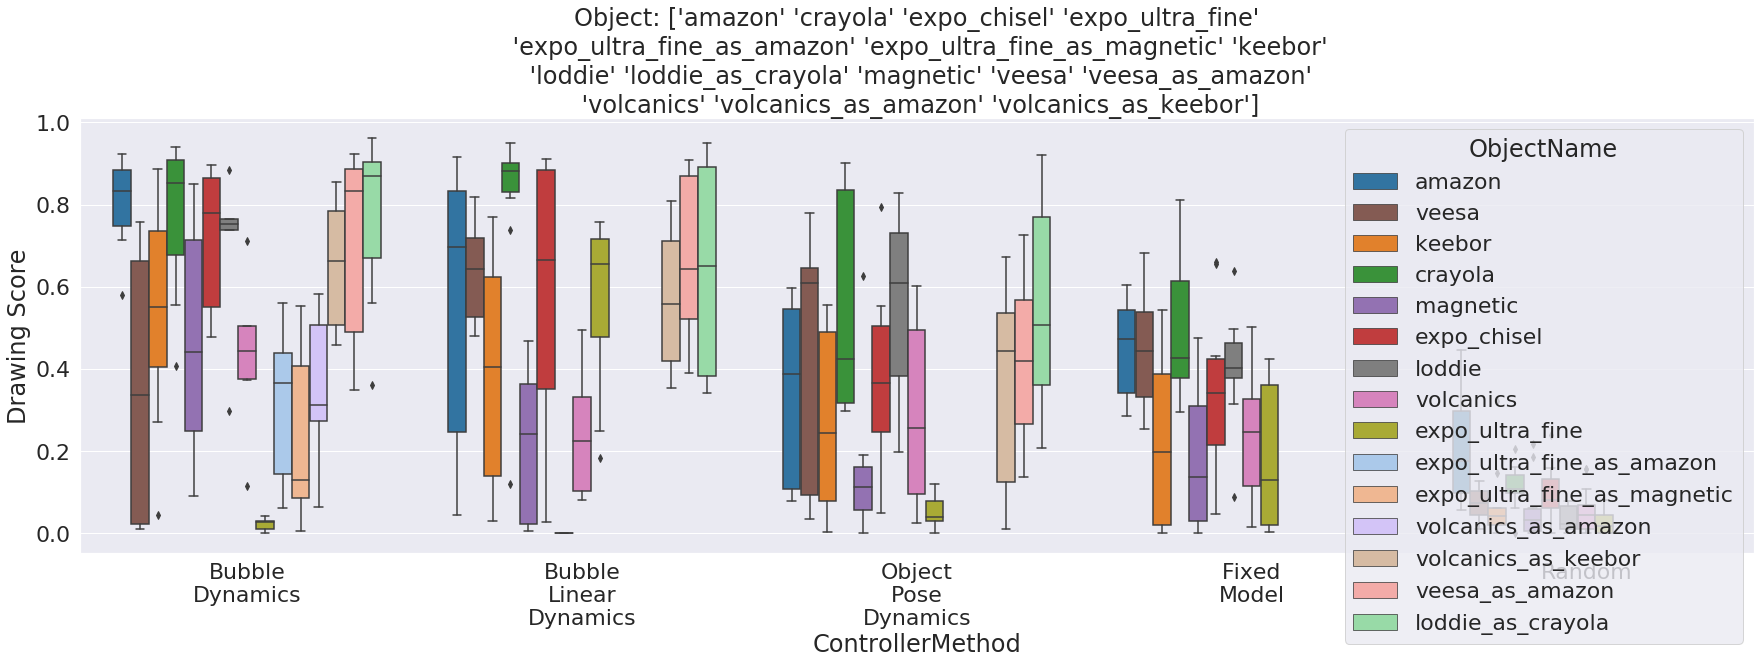

In [15]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=None, hue='ObjectName') # ALL

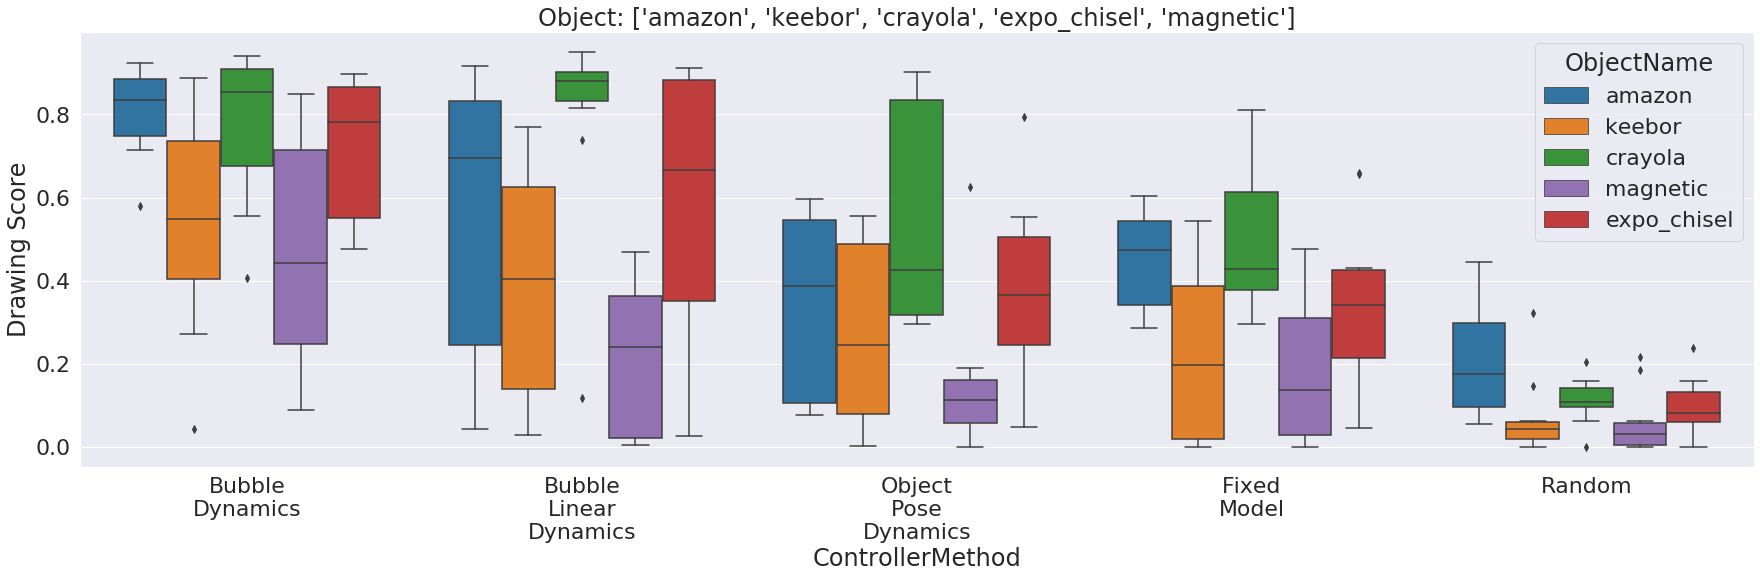

In [16]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects, hue='ObjectName') # ALL

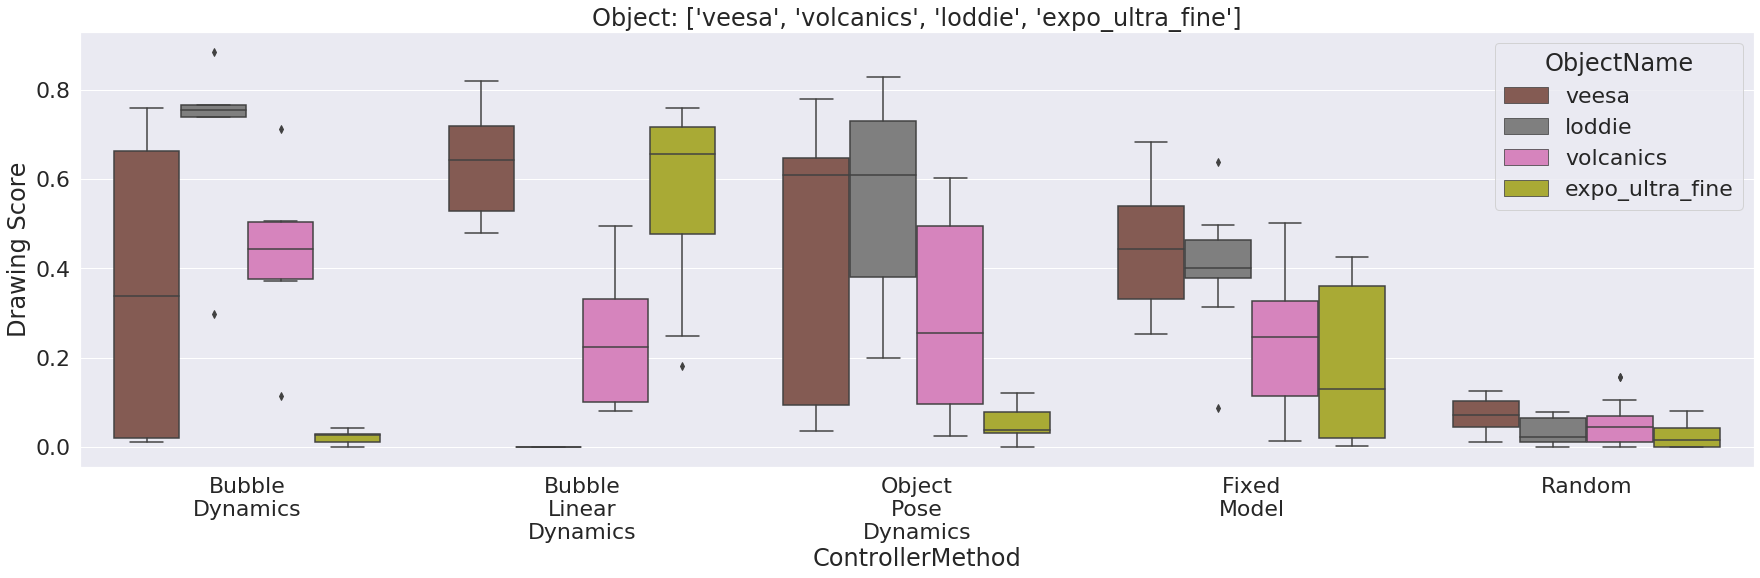

In [17]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects, hue='ObjectName') # ALL

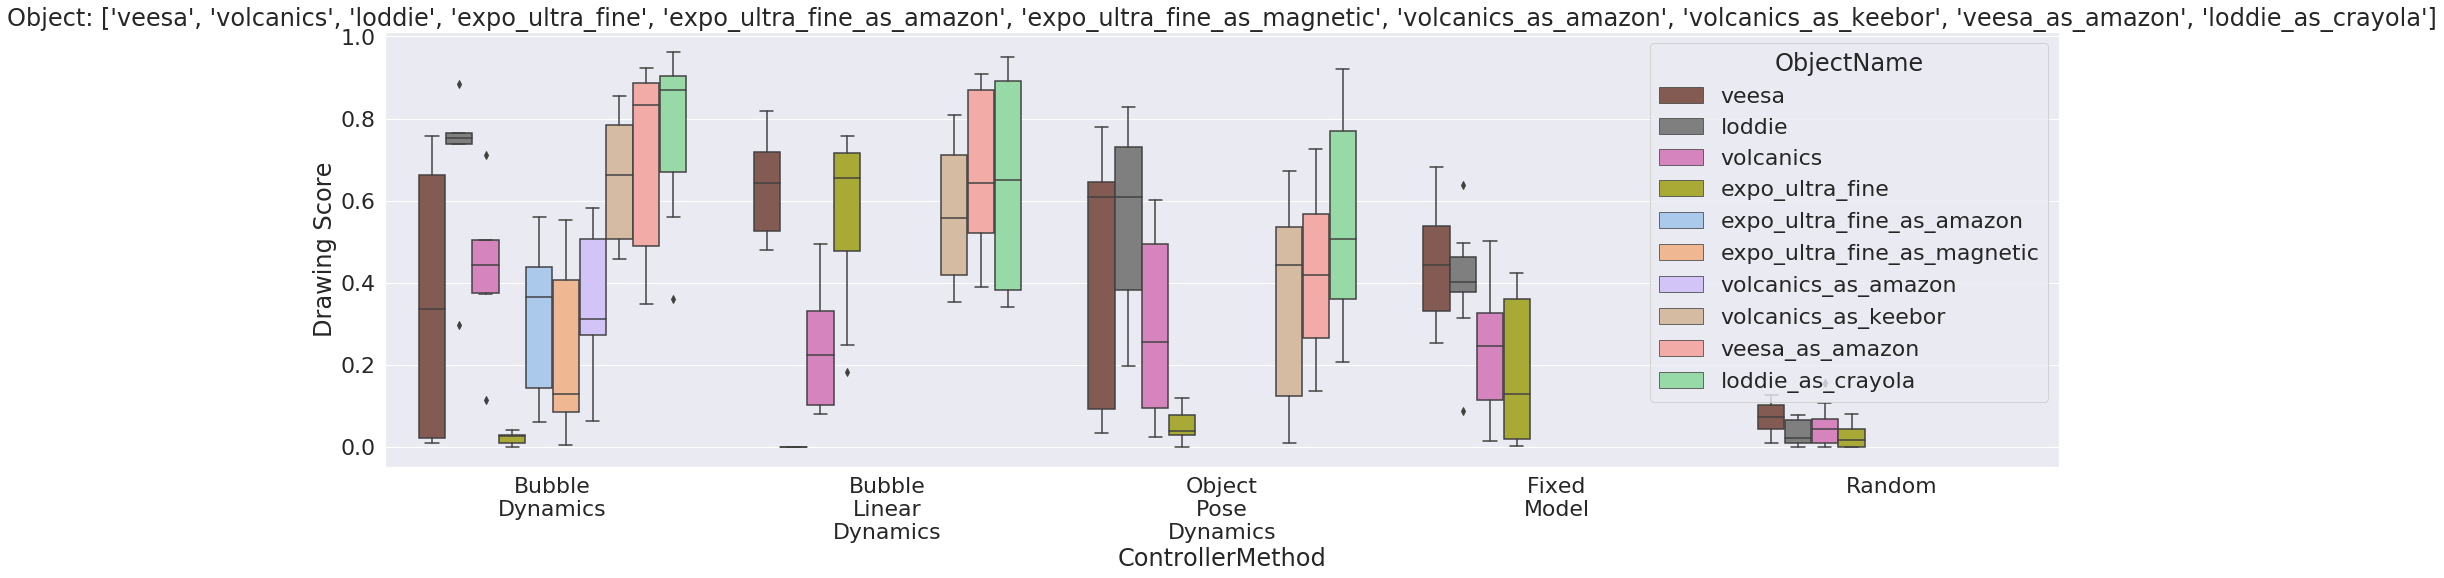

In [18]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects_extended, hue='ObjectName') # ALL

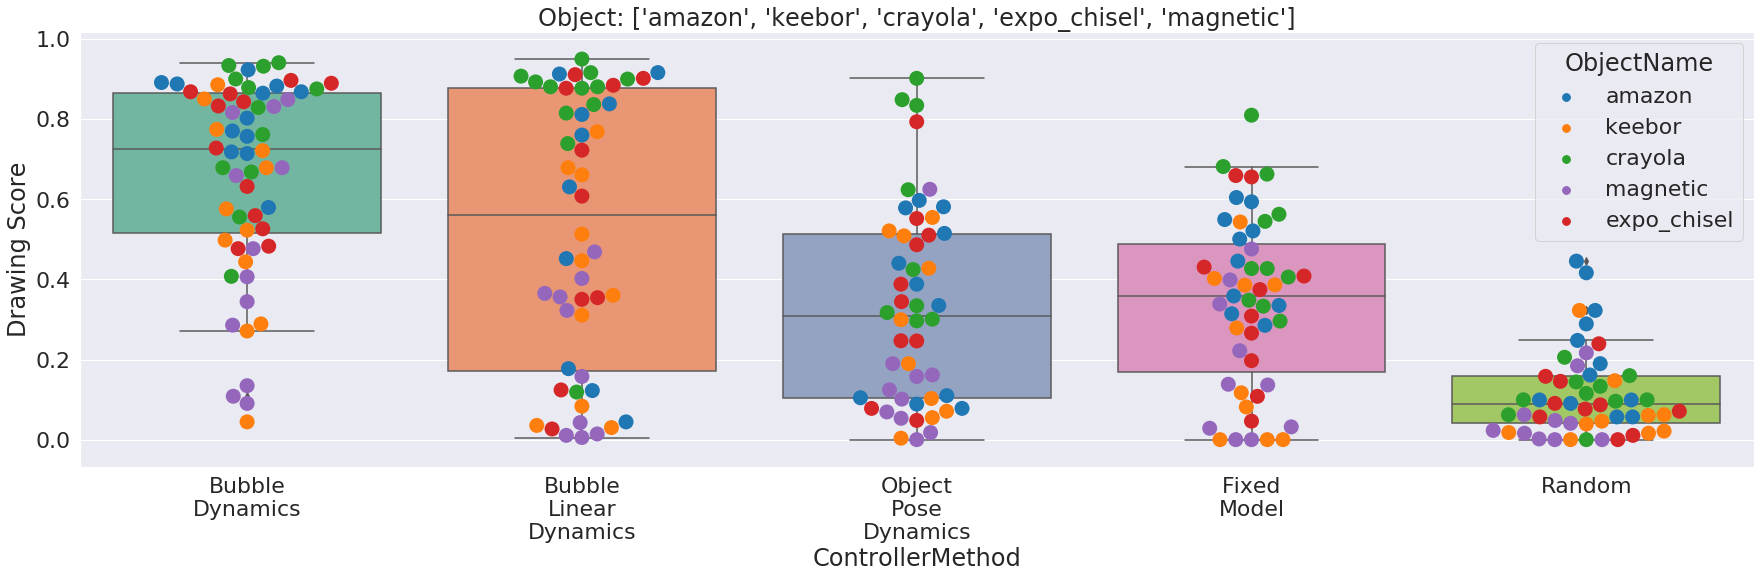

In [19]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects) # ALL
ax_2 = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects, hue='ObjectName')

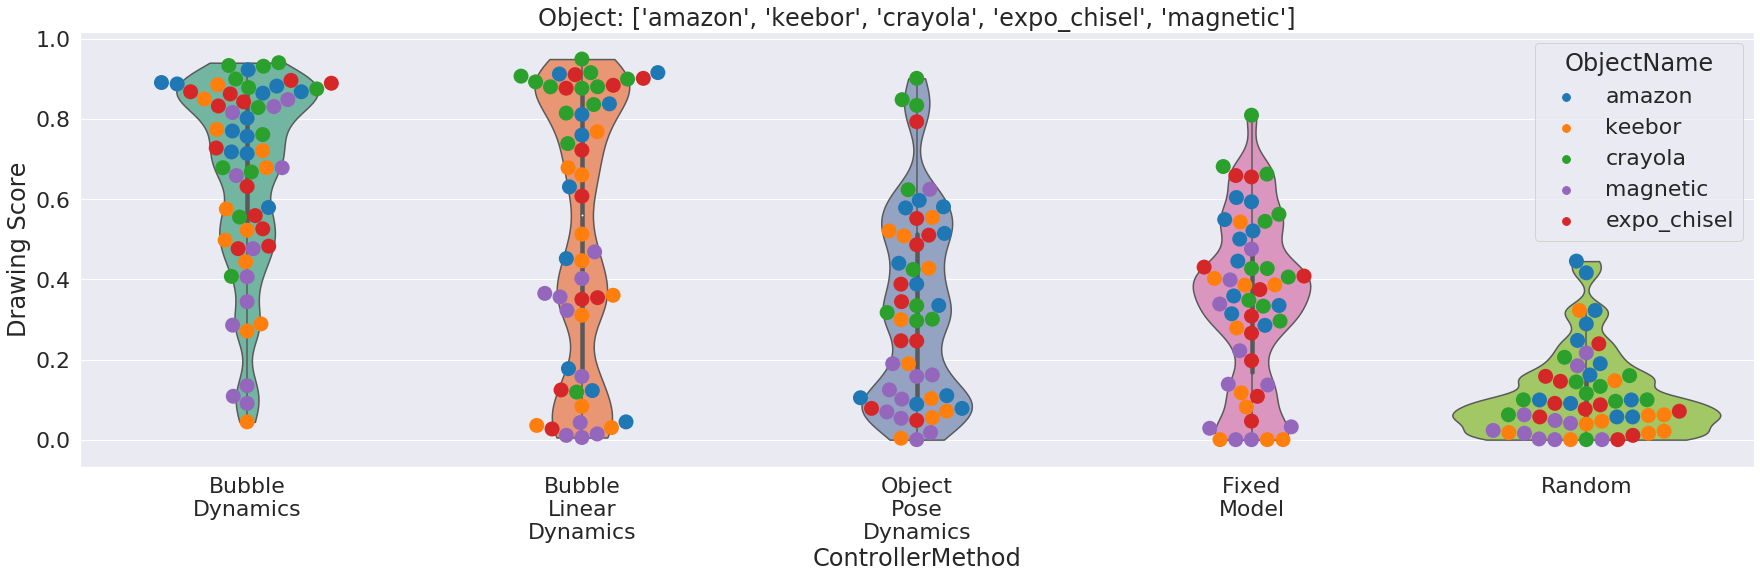

In [20]:
ax = score_violin_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects) # ALL
ax_2 = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects, hue='ObjectName')
# ax_3 = custom_score_mean_std_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects)

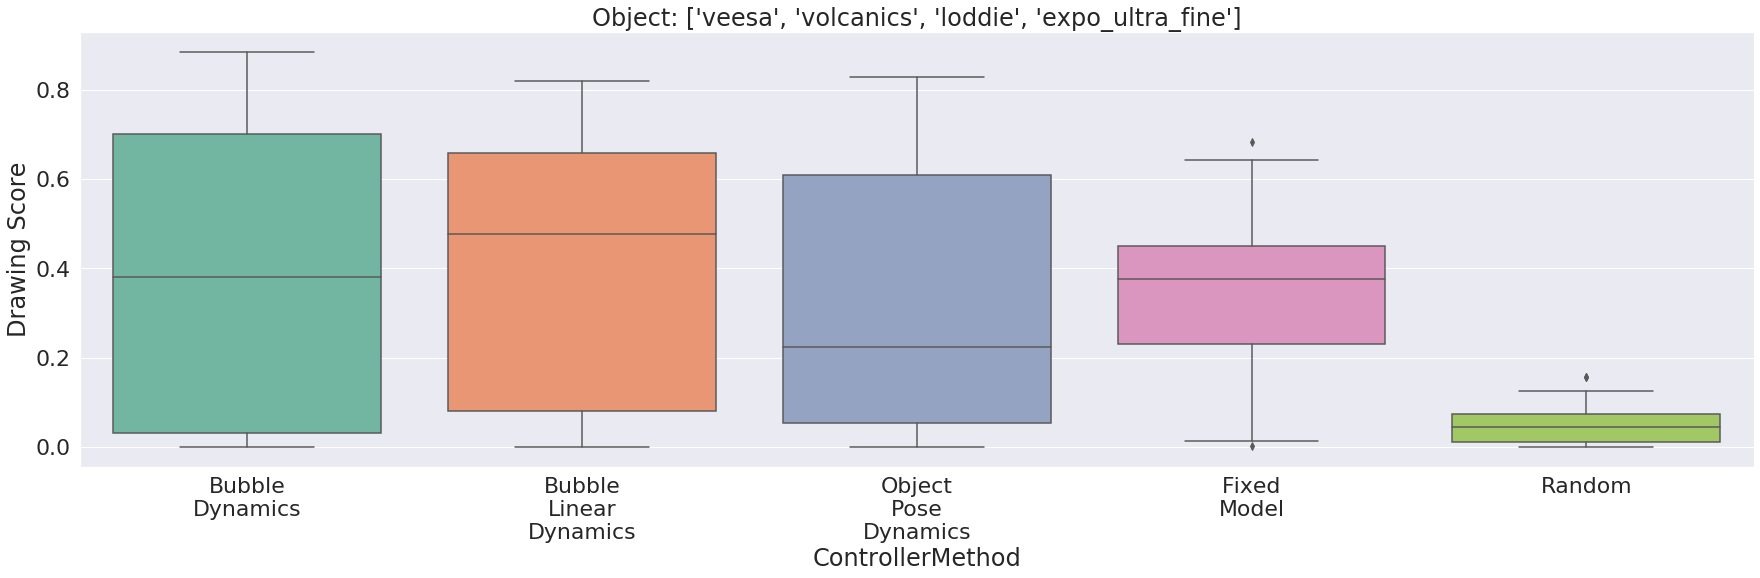

In [21]:
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects) # ALL

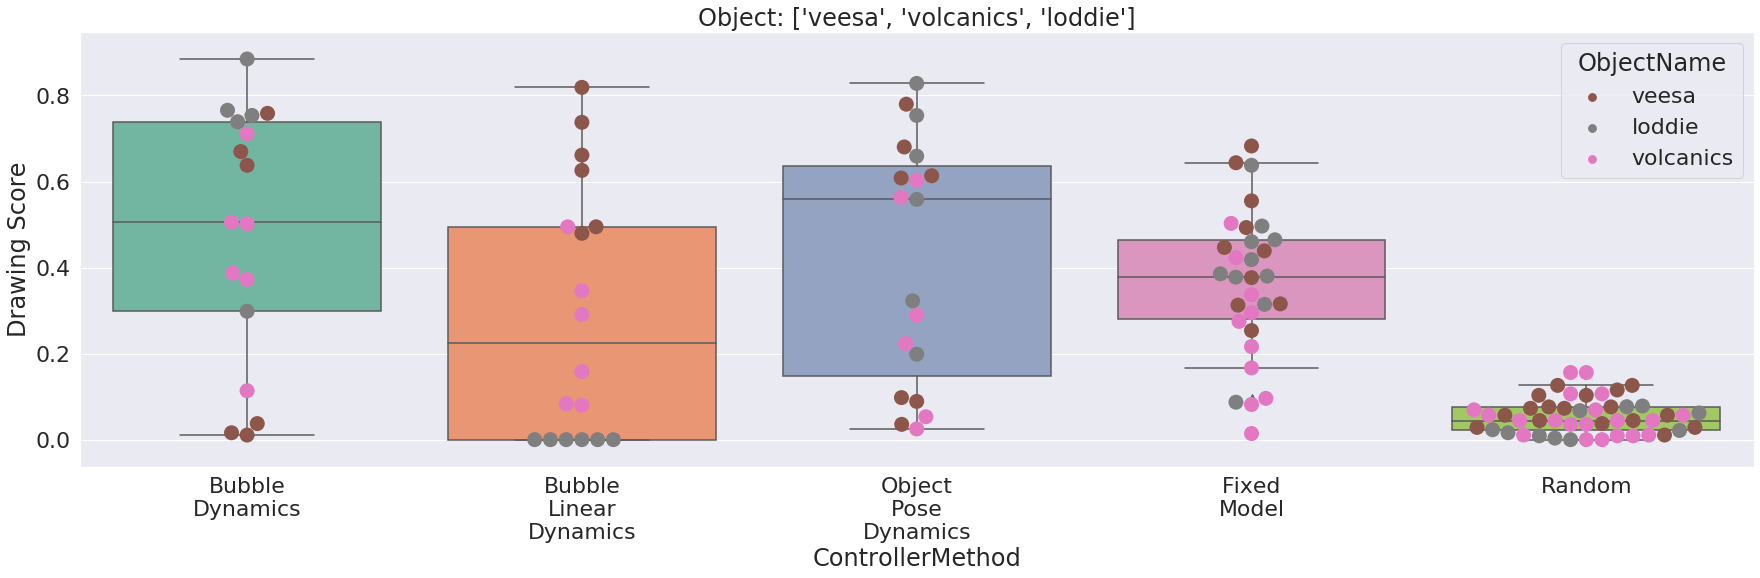

In [22]:
custom_object_selection = ['veesa', 'volcanics', 'loddie']
ax = score_box_plot(df_updated_icp, 'line_masked_scores', object_name=custom_object_selection) # ALL
ax_2 = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=custom_object_selection, hue='ObjectName') # ALL

/tmp/ipykernel_1460052/2061399559.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


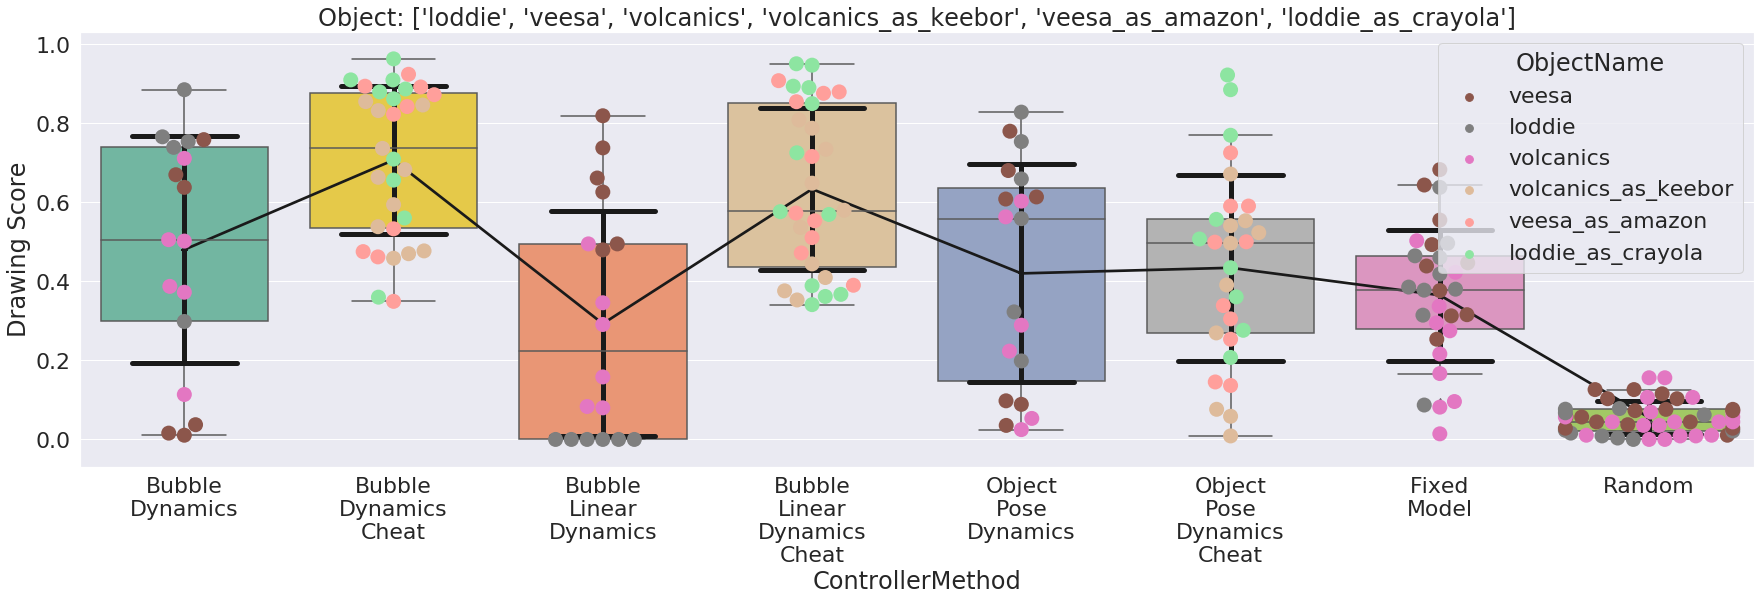

In [23]:
# filter the dataset to only get fixed model and random
original_markers = ['loddie', 'veesa', 'volcanics']
cheat_model_markers = ['volcanics_as_keebor', 'veesa_as_amazon','loddie_as_crayola']
extended_custom_object_selection = original_markers + cheat_model_markers
df_old = df_updated_icp[df_updated_icp['ObjectName'].isin(original_markers)]
df_obj_model_cheat = df_updated_icp[df_updated_icp['ObjectName'].isin(cheat_model_markers)]
df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
df_cheat = pd.concat([df_old, df_obj_model_cheat], ignore_index=True)

ax = score_box_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection) # ALL
ax_2 = score_swarm_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection, hue='ObjectName') # ALL
ax_3 = custom_score_mean_std_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection)

/tmp/ipykernel_1460052/2345013283.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


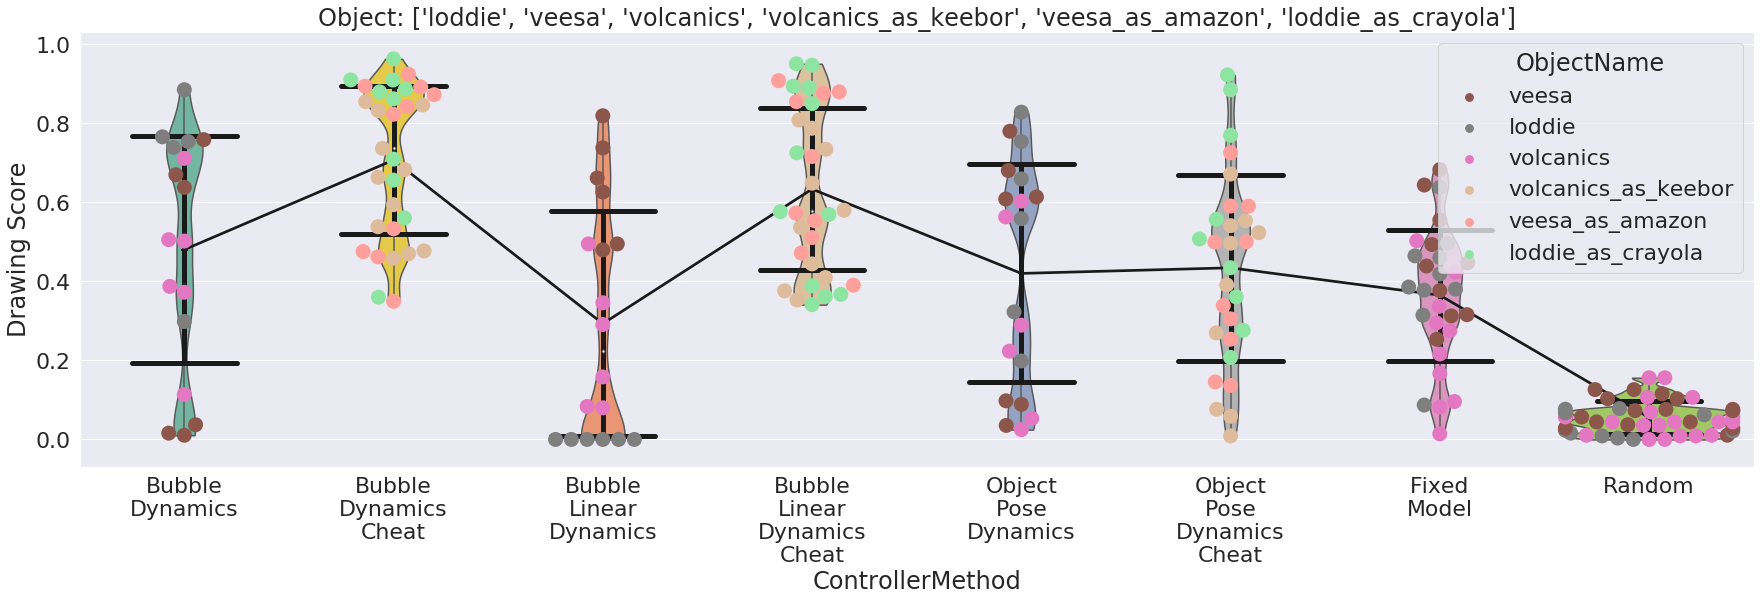

In [24]:
# filter the dataset to only get fixed model and random
original_markers = ['loddie', 'veesa', 'volcanics']
cheat_model_markers = ['volcanics_as_keebor', 'veesa_as_amazon','loddie_as_crayola']
extended_custom_object_selection = original_markers + cheat_model_markers
df_old = df_updated_icp[df_updated_icp['ObjectName'].isin(original_markers)]
df_obj_model_cheat = df_updated_icp[df_updated_icp['ObjectName'].isin(cheat_model_markers)]
df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
df_cheat = pd.concat([df_old, df_obj_model_cheat], ignore_index=True)


ax = score_violin_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection) # ALL
ax_2 = score_swarm_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection, hue='ObjectName')
ax_3 = custom_score_mean_std_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection)

/tmp/ipykernel_1460052/1462676574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_test_fixed_random['ControllerMethod'] = df_old_test_fixed_random['ControllerMethod'] + '_test'
/tmp/ipykernel_1460052/1462676574.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the

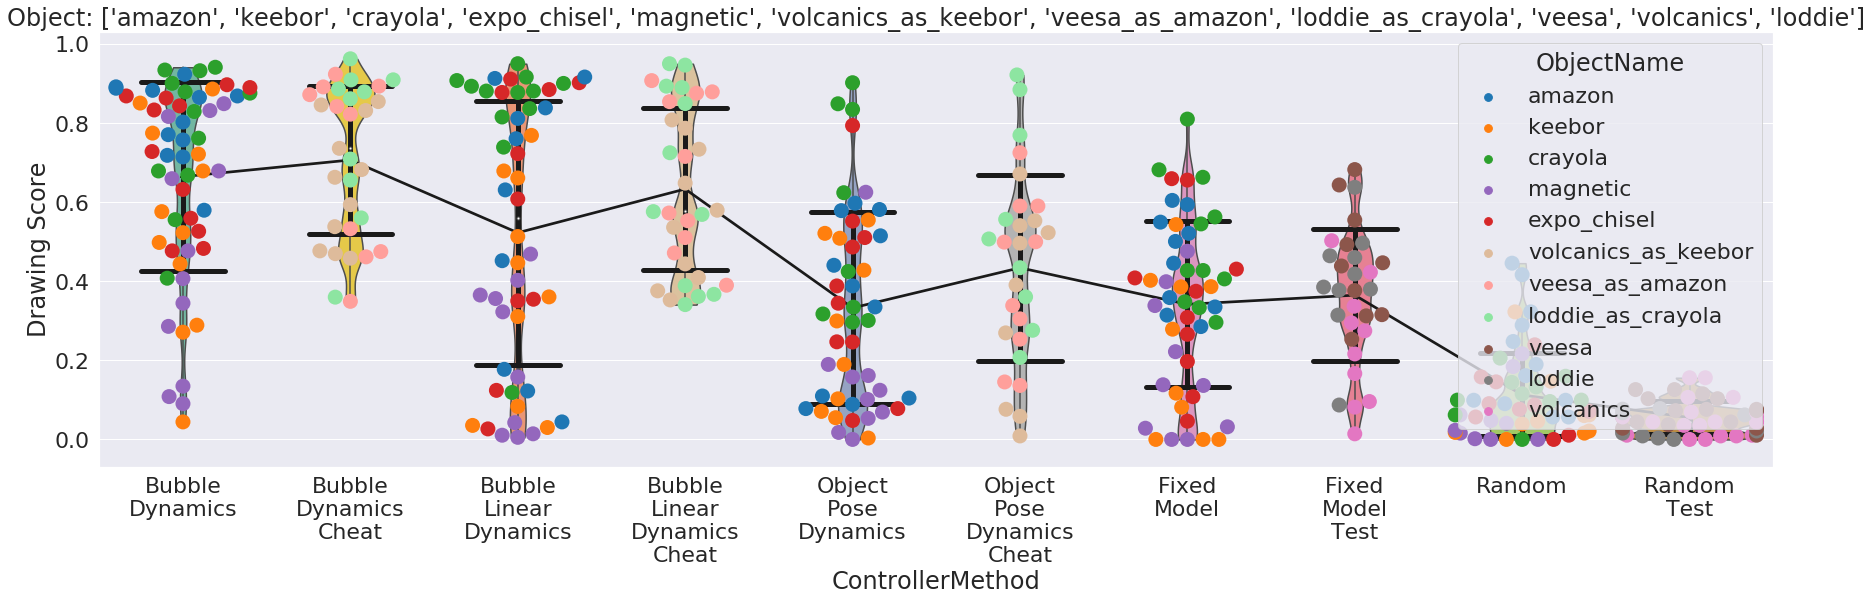

In [46]:
# filter the dataset to only get fixed model and random
original_markers = train_objects

cheat_model_markers = ['volcanics_as_keebor', 'veesa_as_amazon','loddie_as_crayola']
extended_custom_object_selection = original_markers + cheat_model_markers + test_objects_reduced
df_old = df_updated_icp[df_updated_icp['ObjectName'].isin(original_markers)]
df_old_test = df_updated_icp[df_updated_icp['ObjectName'].isin(test_objects_reduced)]
df_old_test_fixed_random = df_old_test[df_old_test['ControllerMethod'].isin(['bubble_dynamics_fixed_model_mppi', 'random_action'])]
df_old_test_fixed_random['ControllerMethod'] = df_old_test_fixed_random['ControllerMethod'] + '_test'

df_obj_model_cheat = df_updated_icp[df_updated_icp['ObjectName'].isin(cheat_model_markers)]
df_obj_model_cheat['ControllerMethod'] = df_obj_model_cheat['ControllerMethod'] + '_cheat'
df_cheat = pd.concat([df_old, df_obj_model_cheat, df_old_test_fixed_random], ignore_index=True)


ax = score_violin_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection) # ALL
ax_2 = score_swarm_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection, hue='ObjectName')
ax_3 = custom_score_mean_std_plot(df_cheat, 'line_masked_scores', object_name=extended_custom_object_selection)

['Bubble_Dynamics_Cheated' 'bubble_dynamics_fixed_model_mppi'
 'bubble_dynamics_model_mppi' 'bubble_linear_dynamics_model_mppi'
 'object_pose_dynamics_model_mppi' 'random_action']


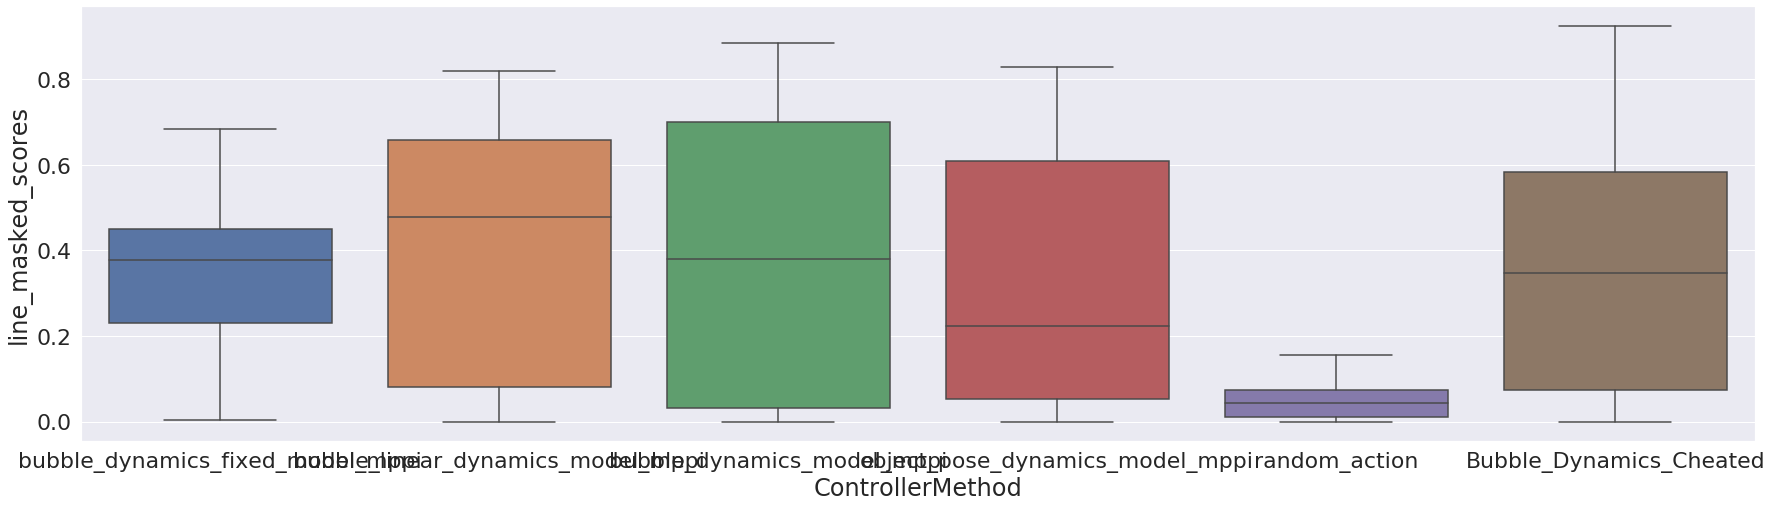

In [26]:
custom_object_selection = ['veesa', 'volcanics', 'volcanics_as_keebor', 'loddie', 'veesa_as_amazon']
df_filtered = df_updated_icp.copy()
df_filtered = df_filtered[(df_filtered['ControllerMethod'] != 'bubble_dynamics_model_mppi') | ( df_filtered['ObjectName'] != 'volcanics')]
df_filtered = df_filtered[(df_filtered['ControllerMethod'] != 'bubble_dynamics_model_mppi') | ( df_filtered['ObjectName'] != 'veesa')]
df_filtered_dynamics = df_filtered[df_filtered['ControllerMethod'] == 'bubble_dynamics_model_mppi']
df_filtered['ControllerMethod'] = 'Bubble_Dynamics_Cheated'
df_filtered = df_filtered[df_filtered['ObjectName'].isin(custom_object_selection)]
base_df = df_updated_icp[df_updated_icp['ObjectName'].isin(test_objects)]
df_extended = pd.concat([base_df, df_filtered], ignore_index=True)
print(np.unique(df_extended['ControllerMethod']))
len(df_extended)
df_extended
ax = sns.boxplot(data=df_extended, x='ControllerMethod', y='line_masked_scores')
# ax = score_box_plot(df_extended, 'line_masked_scores', object_name=custom_object_selection) # ALL
# ax_2 = score_swarm_plot(df_extended, 'line_masked_scores', object_name=custom_object_selection, hue='ObjectName') 

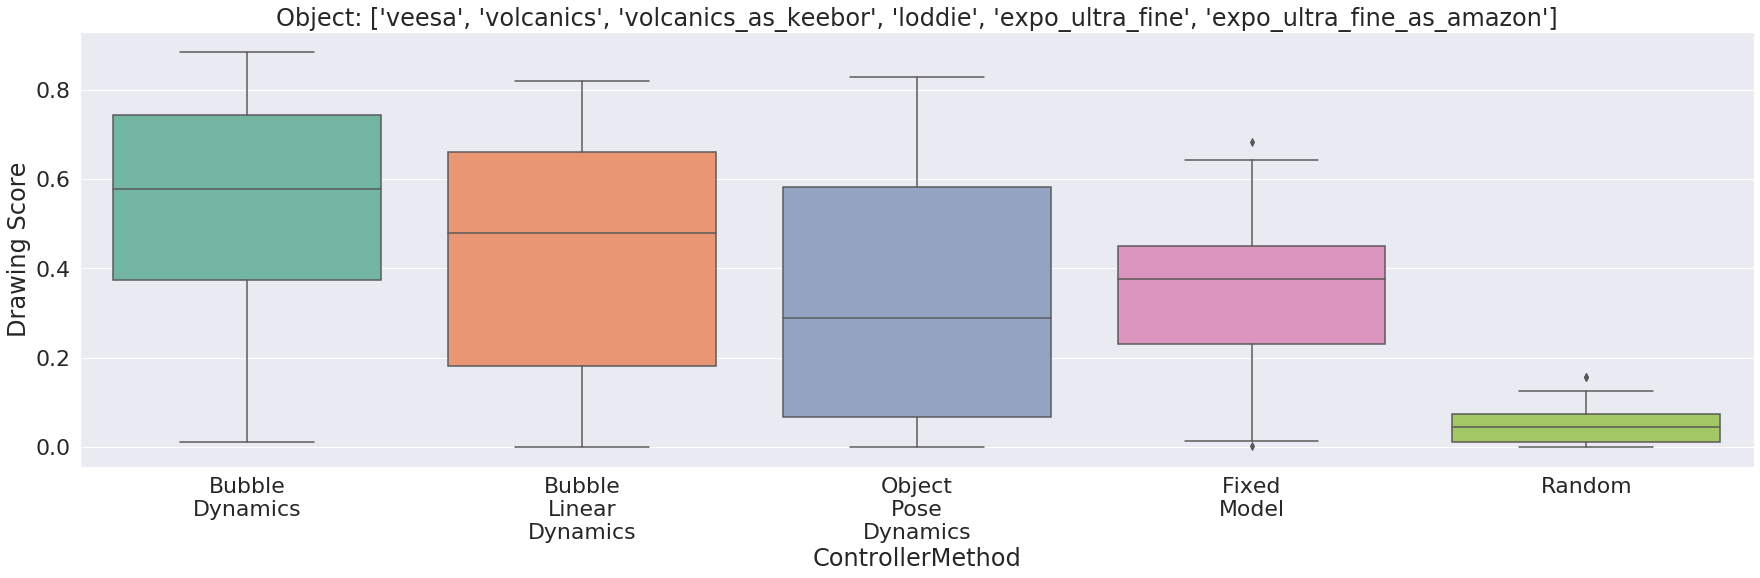

In [27]:
custom_object_selection = ['veesa', 'volcanics', 'volcanics_as_keebor', 'loddie', 'expo_ultra_fine', 'expo_ultra_fine_as_amazon']
df_filtered = df_updated_icp.copy()

# replacing the true evaluation values with the model cheating ones:
df_filtered = df_filtered[(df_filtered['ControllerMethod'] != 'bubble_dynamics_model_mppi') | ( df_filtered['ObjectName'] != 'volcanics')]
df_filtered = df_filtered[(df_filtered['ControllerMethod'] != 'bubble_dynamics_model_mppi') | ( df_filtered['ObjectName'] != 'expo_ultra_fine')]
ax = score_box_plot(df_filtered, 'line_masked_scores', object_name=custom_object_selection) # ALL

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


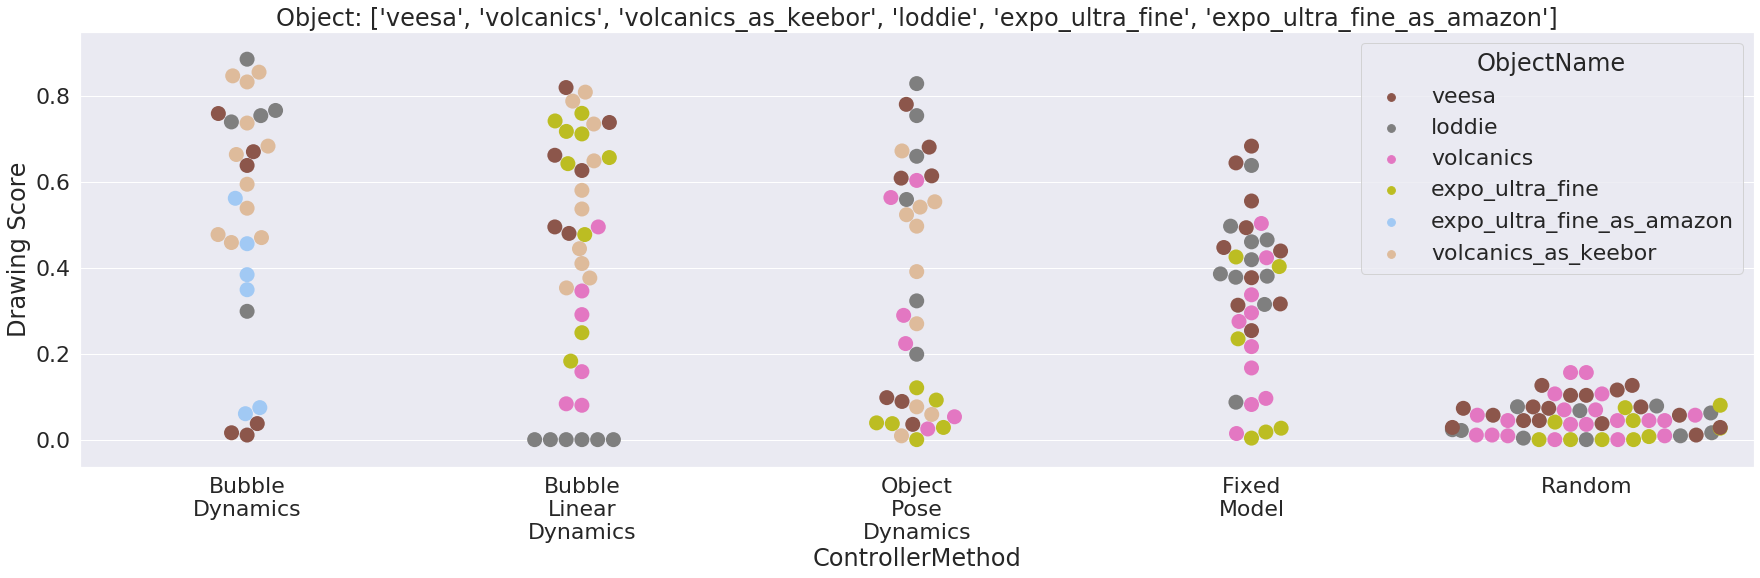

In [28]:
ax = score_swarm_plot(df_filtered, 'line_masked_scores', object_name=custom_object_selection, hue='ObjectName') # ALL

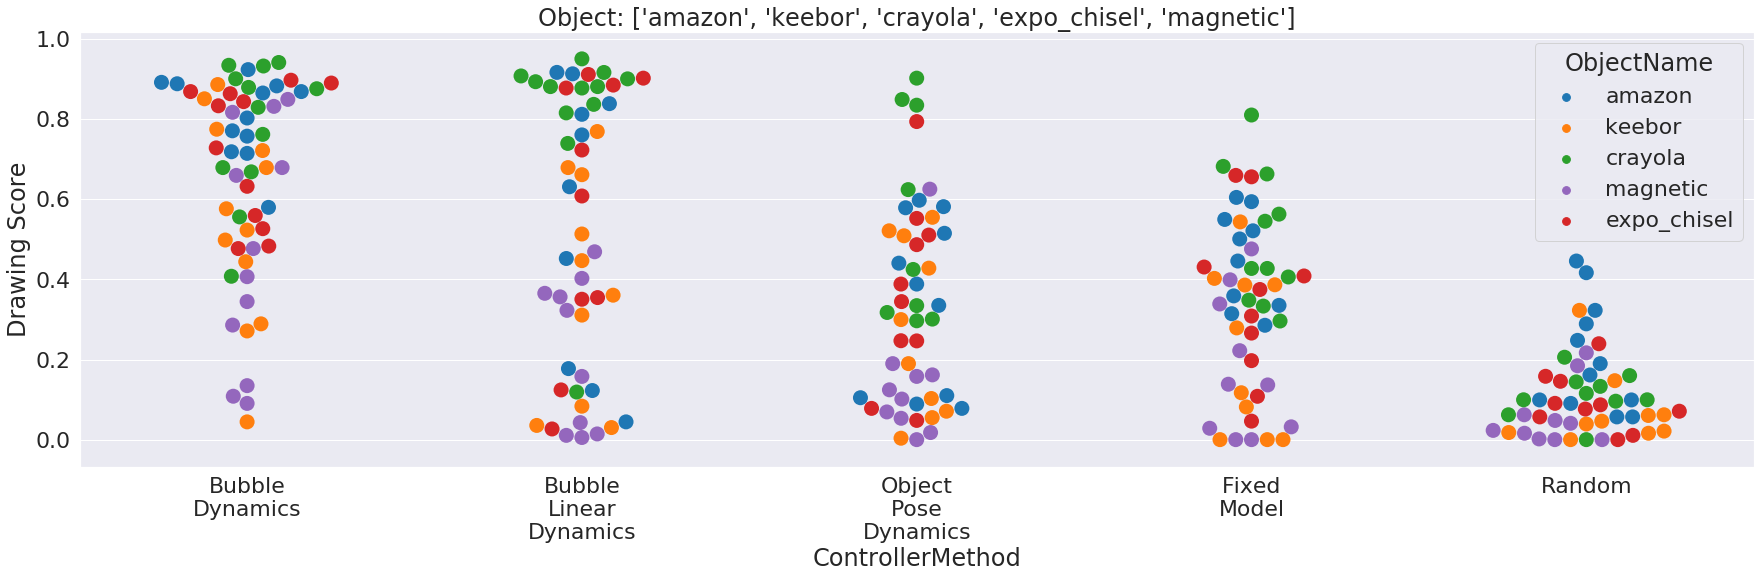

In [29]:
ax = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects, hue='ObjectName') # ALL

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


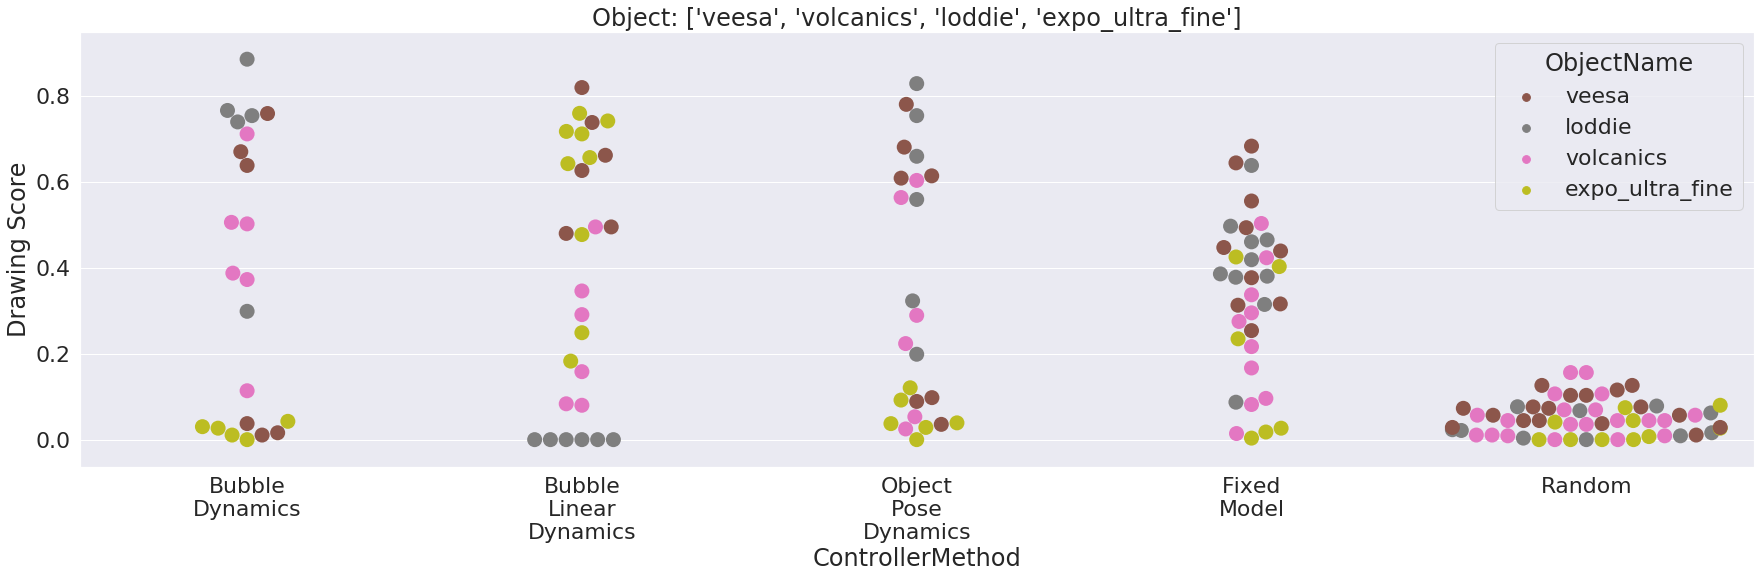

In [30]:
ax = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects, hue='ObjectName') # ALL

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


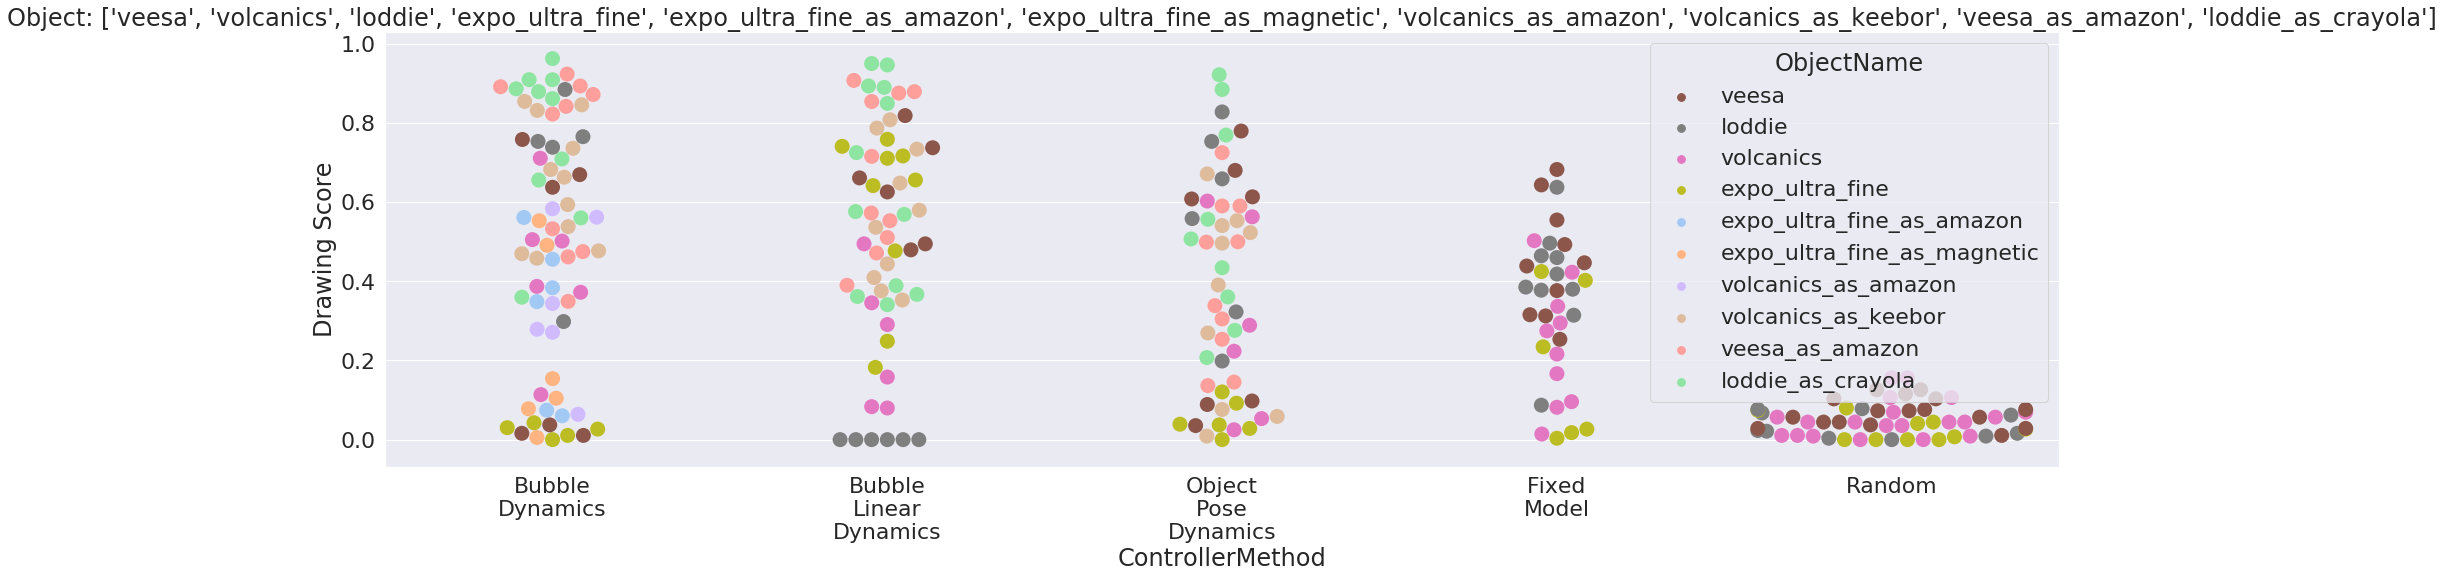

In [31]:
ax = score_swarm_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects_extended, hue='ObjectName') # ALL

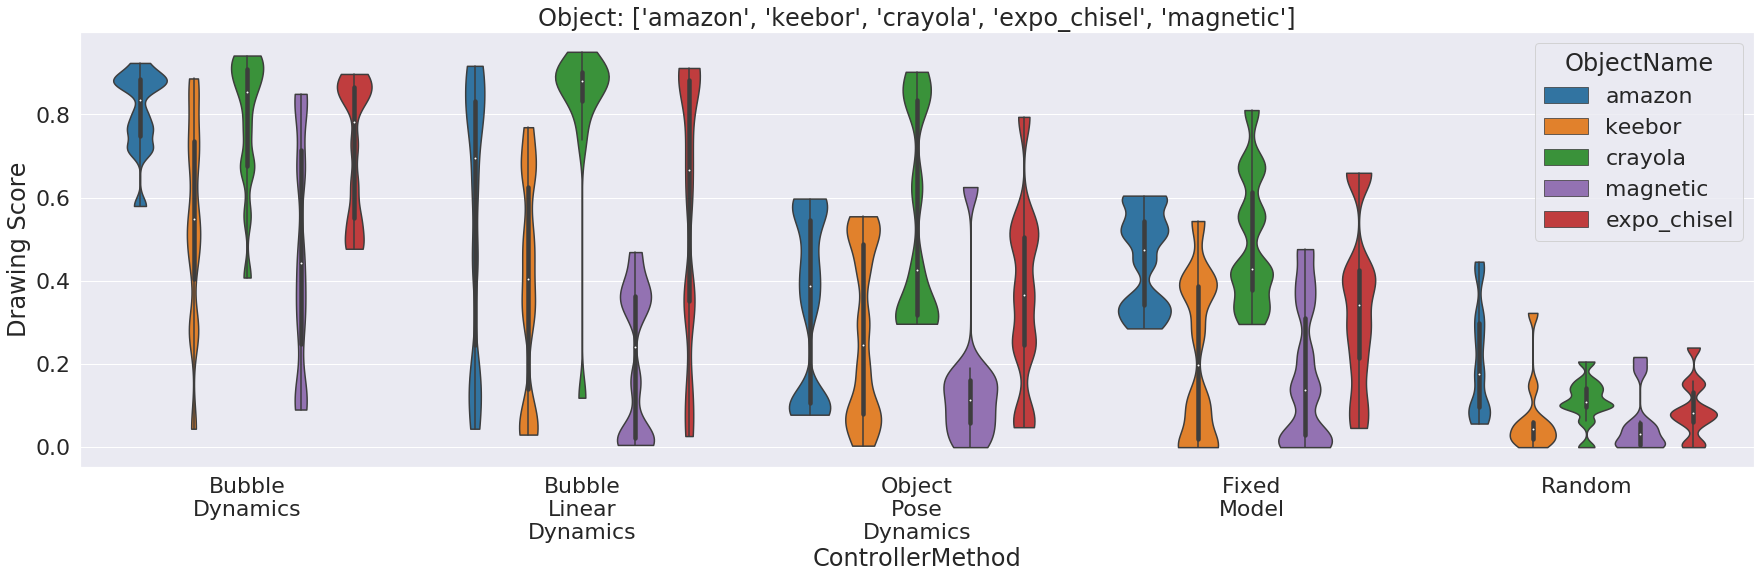

In [32]:
ax = score_violin_plot(df_updated_icp, 'line_masked_scores', object_name=train_objects, hue='ObjectName') # ALL

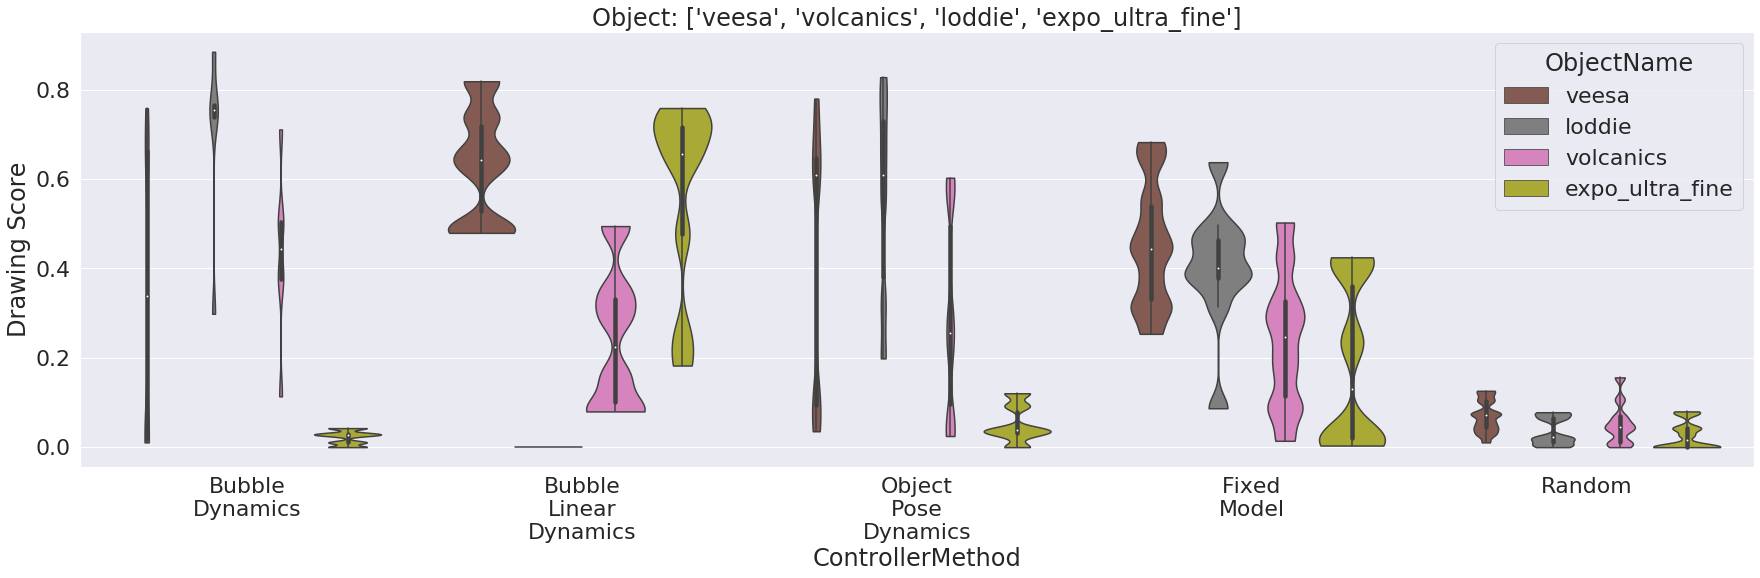

In [33]:
ax = score_violin_plot(df_updated_icp, 'line_masked_scores', object_name=test_objects, hue='ObjectName') # ALL

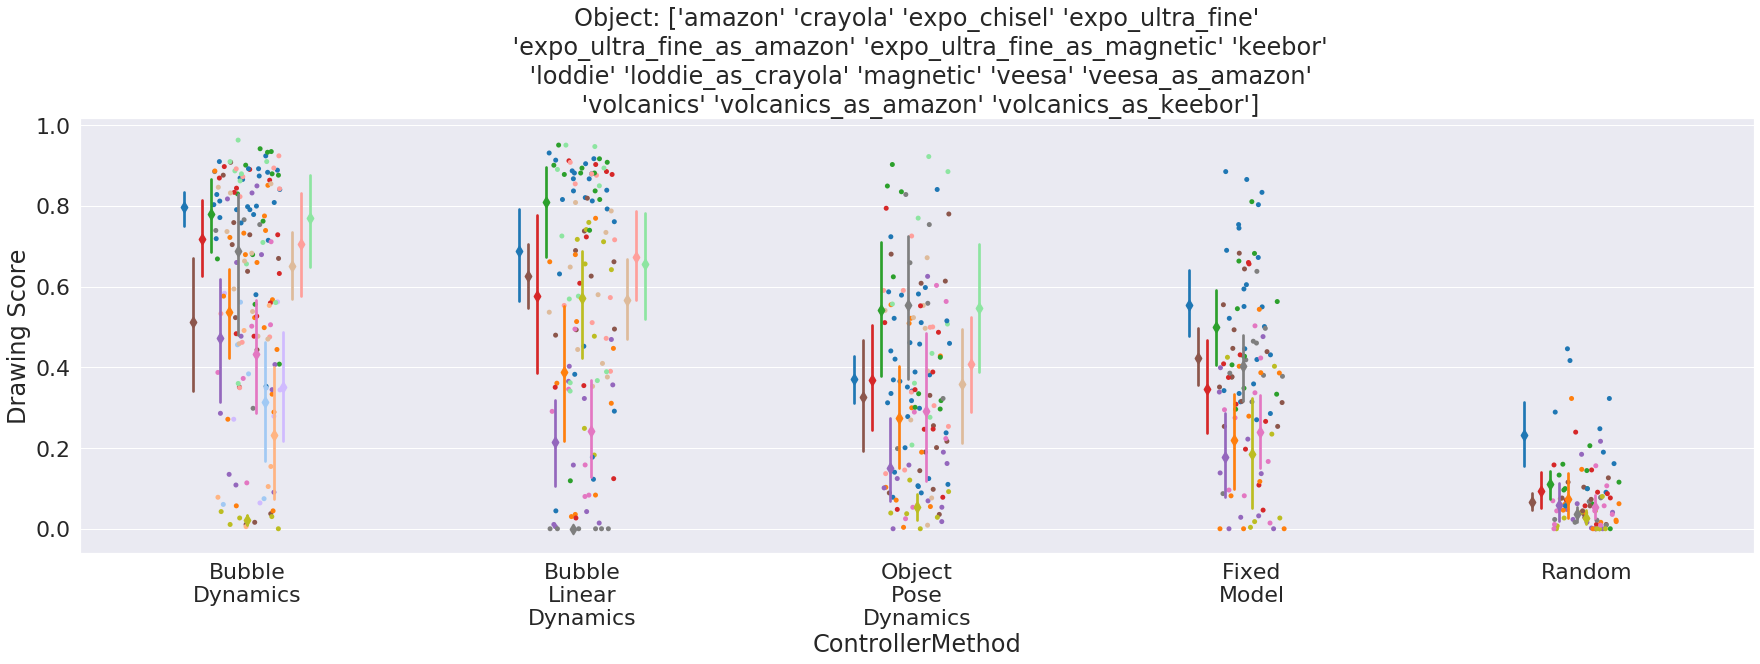

In [34]:
ax = score_strip_plot(loaded_df, 'line_masked_scores', object_name=None, hue='ObjectName') # ALL

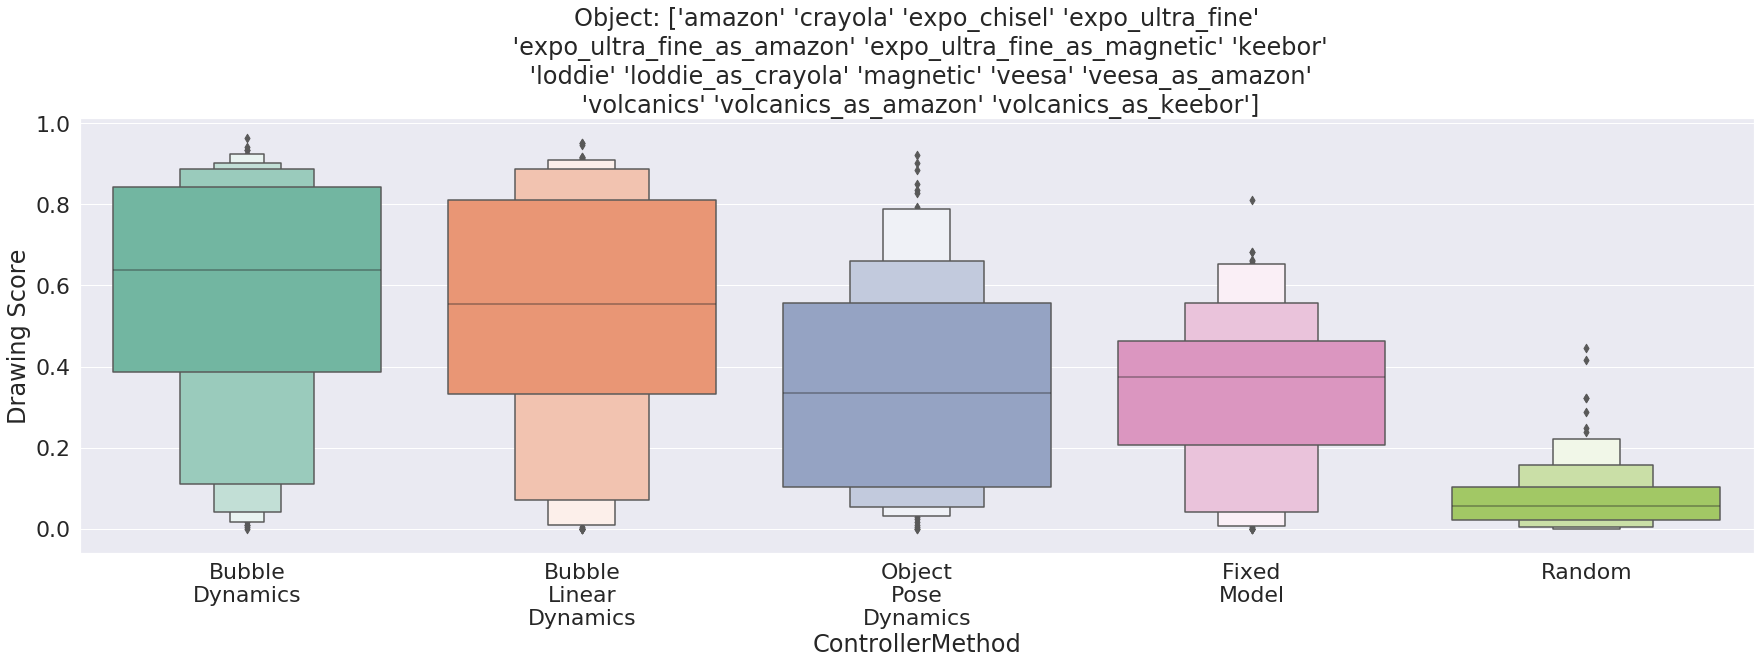

In [35]:
ax = score_boxen_plot(df_updated_icp, 'line_masked_scores', object_name=None) # ALL

In [36]:
df = df_updated_icp#[df_updated_icp['SceneName'] == 'line_drawing_updated_icp_approx']
unique_models, sample_counts = np.unique(df['ControllerMethod'], return_counts=True)
data = []
for i, model_name in enumerate(unique_models):
    df_model = df[df['ControllerMethod'] == model_name]
    unique_object_i, counts_i = np.unique(df_model['ObjectName'], return_counts=True)
    print(model_name + ' ------ {}'.format(sample_counts[i]))                                   
    for o_i, object_name_i in enumerate(unique_object_i):
        print('\t {} - {}'.format(object_name_i, counts_i[o_i]))
        data.append([model_name, object_name_i, counts_i[o_i]])
        
counts_df = pd.DataFrame(data, columns=['ControllerMethod', 'ObjectName', 'Counts'])

bubble_dynamics_fixed_model_mppi ------ 87
	 amazon - 10
	 crayola - 11
	 expo_chisel - 10
	 expo_ultra_fine - 6
	 keebor - 10
	 loddie - 10
	 magnetic - 10
	 veesa - 10
	 volcanics - 10
bubble_dynamics_model_mppi ------ 131
	 amazon - 12
	 crayola - 12
	 expo_chisel - 12
	 expo_ultra_fine - 5
	 expo_ultra_fine_as_amazon - 6
	 expo_ultra_fine_as_magnetic - 6
	 keebor - 12
	 loddie - 5
	 loddie_as_crayola - 10
	 magnetic - 12
	 veesa - 6
	 veesa_as_amazon - 10
	 volcanics - 6
	 volcanics_as_amazon - 6
	 volcanics_as_keebor - 11
bubble_linear_dynamics_model_mppi ------ 111
	 amazon - 10
	 crayola - 12
	 expo_chisel - 10
	 expo_ultra_fine - 9
	 keebor - 10
	 loddie - 6
	 loddie_as_crayola - 12
	 magnetic - 10
	 veesa - 6
	 veesa_as_amazon - 10
	 volcanics - 6
	 volcanics_as_keebor - 10
object_pose_dynamics_model_mppi ------ 104
	 amazon - 11
	 crayola - 9
	 expo_chisel - 10
	 expo_ultra_fine - 6
	 keebor - 10
	 loddie - 6
	 loddie_as_crayola - 9
	 magnetic - 10
	 veesa - 7
	 veesa_as_amaz

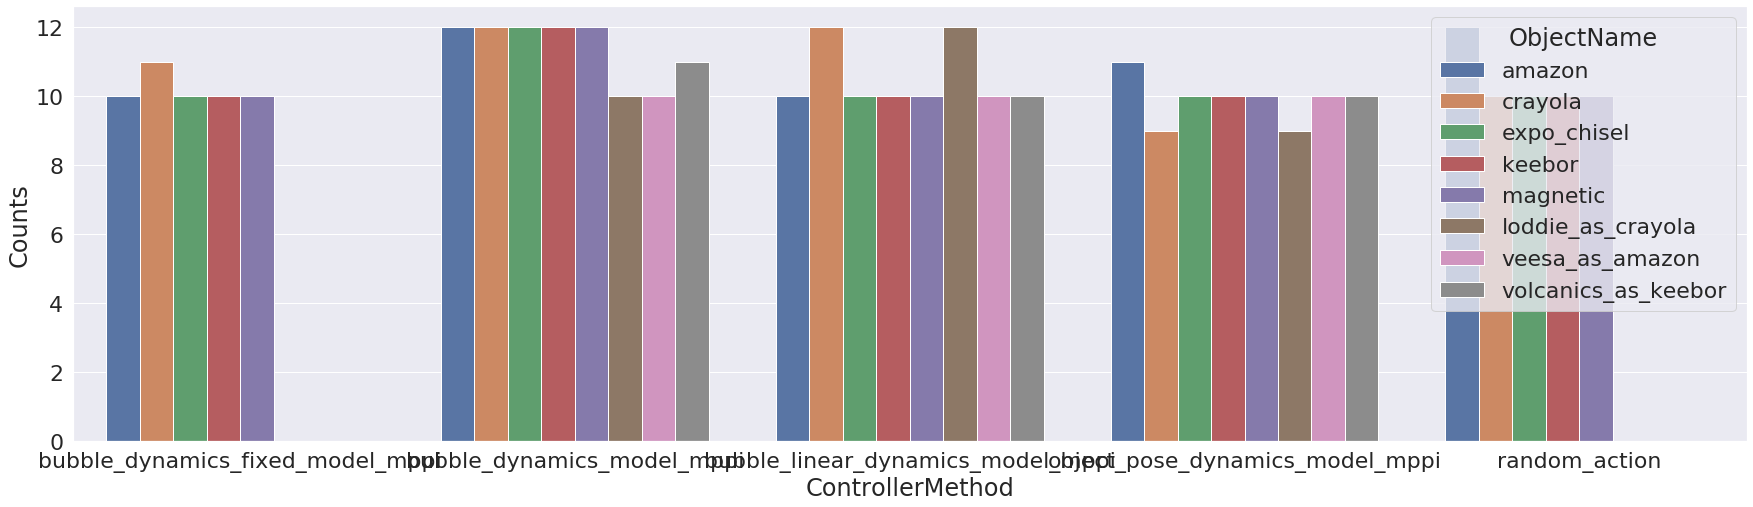

In [45]:
sns.barplot(data=counts_df[counts_df['ObjectName'].isin(train_objects+cheat_model_markers)], x='ControllerMethod', y='Counts', hue='ObjectName')

----

----

----

In [38]:
def compute_score(actual_drawing, desired_drawing):
    img_th = 50
    current_drawing_pixels = np.stack(np.where(actual_drawing > img_th), axis=-1)
    desired_drawing_pixels = np.stack(np.where(desired_drawing > img_th), axis=-1)
    tree = KDTree(current_drawing_pixels)
    min_dists, min_indxs = tree.query(desired_drawing_pixels)
    score = np.mean(min_dists)
    return score

In [39]:
def compute_masked_score(actual_drawing, desired_drawing):
    actual_drawing_norm = np.divide(actual_drawing.astype(np.float32), actual_drawing.astype(np.float32), out=np.zeros_like(actual_drawing, dtype=np.float32), where=actual_drawing!=0)
    desired_drawing_norm = np.divide(desired_drawing.astype(np.float32), desired_drawing.astype(np.float32), out=np.zeros_like(desired_drawing, dtype=np.float32), where=desired_drawing!=0)
    score = np.sum(desired_drawing_norm * actual_drawing_norm)
    return score

----

In [40]:
import scipy
import matplotlib.pyplot as plt

from scipy.stats import beta

In [41]:

def beta_plots(df, controller_methods, object_names, score_name):
    beta_dists = {}
    fig, ax = plt.subplots(1, 1)
    
    x = np.linspace(0, 1, 100)
    
    for i, controller_method in enumerate(controller_methods):
        data_df = df[df['ControllerMethod'] == controller_method]
        data_df = data_df[data_df['ObjectName'].isin(object_names)]
        scores = data_df[score_name]
        beta_params = beta.fit(scores)
        a, b, loc, scale = beta_params
        mean_i = np.mean(scores)
        std_i = np.std(scores)
        label_i = control_name_mapping[controller_method]
        color_i = np.array(palette[controller_method])
#         ax.hist(scores, label=label_i, color=color_i, alpha=0.2)
        ax.plot(x, beta.pdf(x, a, b), label=label_i, color=color_i, lw=10.0)
        ax.axvline(x=mean_i, color=color_i, lw=15.0)
        beta_params_i = {
            'alpha': a,
            'beta': b, 
            'mean': mean_i,
            'std': std_i,
            'loc': loc,
            'scale': scale,
        }
        beta_dists[controller_method] = beta_params_i
        ax.legend()
        
    return beta_dists
        
    

/usr/local/lib/python3.8/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


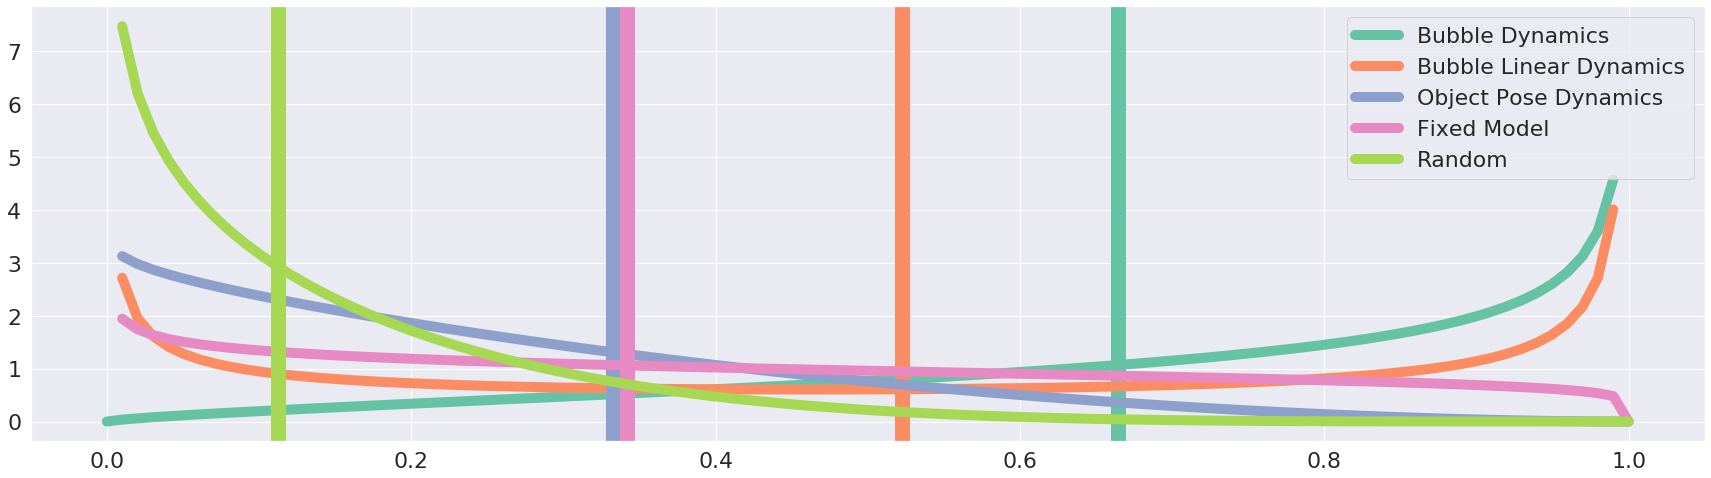

In [42]:
beta_dists = beta_plots(df_updated_icp, control_name_mapping_base.keys(), object_names=train_objects, score_name='line_masked_scores')


In [43]:
beta_dists_df = pd.DataFrame(beta_dists, columns=)
beta_dists_df

SyntaxError: invalid syntax (3600323434.py, line 1)

In [ ]:
1.7215/(1.7215+0.66717)

In [ ]:
beta_dists = beta_plots(df_cheat, control_name_mapping_base.keys(), object_names=extended_custom_selection, score_name='line_masked_scores')
